In [2]:
!git clone https://github.com/NimayRKumar/in_the_jungle.git

Cloning into 'in_the_jungle'...
remote: Enumerating objects: 950, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 950 (delta 33), reused 92 (delta 21), pack-reused 843
Receiving objects: 100% (950/950), 104.01 MiB | 34.28 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (893/893), done.


In [3]:
%cd in_the_jungle/
!pip install -r requirements.txt

/content/in_the_jungle
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.3 MB/s eta 0:00:00


In [4]:
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy
import pickle

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data Preprocess

In [6]:
def get_spectrogram(signal, hop_length=512, n_fft=2048):
  stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
  spectrogram = np.abs(stft)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)

In [8]:
from preprocess import create_signal_dataframe

In [9]:
df = create_signal_dataframe()
signal = np.vstack(df["signal"])
label = np.array(df["label"])
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train)
print(mfcc_train.shape)

spectrogram_test = get_spectrogram(x_test)
print(spectrogram_test.shape)

mfcc_test = get_mfcc(x_test)
print(mfcc_test.shape)

(700, 44100) (700,) (175, 44100) (175,)
(700, 1025, 87)
(700, 13, 87)
(175, 1025, 87)
(175, 13, 87)


In [10]:
def create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35):
  train_data_spectrogram = []
  train_data_mfcc = []
  for i in range(spectrogram_train.shape[0]):
      train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
      train_data_mfcc.append((mfcc_train[i], y_train[i]))
  train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=batch_ize)
  train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=batch_ize)
  return train_loader_spectrogram, train_loader_mfcc

In [11]:
train_loader_spectrogram, train_loader_mfcc = create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35)

In [12]:
test_loader_spectrogram, test_loader_mfcc = create_loader(spectrogram_test, mfcc_test, y_test, batch_ize=5)

Train VGG model

In [13]:
class VGG16Mfcc(nn.Module):
    def __init__(self, num_classes=10, batch_size=35):
        super(VGG16Mfcc, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, batch_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(batch_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(batch_size, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(512 * 3 * 21, 4096), nn.ReLU()
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(4096, num_classes))

    def forward(self, x):
        # print("input", x.shape)
        out = self.layer1(x)
        # print("l1", out.shape)
        out = self.layer2(out)
        # print("l2", out.shape)
        out = self.layer3(out)
        # print("l3", out.shape)
        out = self.layer4(out)
        # print("l4 before", out.shape)
        out = out.view(out.shape[0], -1)
        # print("l4", out.shape)
        out = self.fc(out)
        # print("l5", out.shape)
        out = self.fc1(out)
        # print("l6", out.shape)
        out = self.fc2(out)
        # print("l7", out.shape)
        return out

In [14]:
class VGG16Spec(nn.Module):
    def __init__(self, num_classes=10, batch_size=35):
        super(VGG16Spec, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, batch_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(batch_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(batch_size, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(2818048, 128), nn.ReLU()
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(128, 128),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        # print("input", x.shape)
        out = self.layer1(x)
        # print("l1", out.shape)
        out = self.layer2(out)
        # print("l2", out.shape)
        out = self.layer3(out)
        # print("l3", out.shape)
        # out = self.layer4(out)
        # print("l4 before", out.shape)
        out = out.view(out.shape[0], -1)
        # print("l4", out.shape)
        out = self.fc(out)
        # print("l5", out.shape)
        out = self.fc1(out)
        # print("l6", out.shape)
        out = self.fc2(out)
        # print("l7", out.shape)
        return out

In [24]:
num_classes = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.0005

model_mfcc = VGG16Mfcc(num_classes, batch_size).to(device)
model_spec = VGG16Spec(num_classes, batch_size).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Train the model

spec_model_save_path = "model_spectrogram.pth"
mfcc_model_save_path = "model_mfcc.pth"

In [16]:
def validation(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [18]:
def train(model, train_loader, test_loader, num_epochs, criterion, model_save_path, learning_rate):
    best_acc = 0
    train_per_weight_update = []
    val_accu_lst = []
    total_step = len(train_loader) * num_epochs
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9
    )
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 50 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )
        model.eval()
        val_accu = validation(model, test_loader)
        print(
            "Epoch: [{}/{}], Validation Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, val_accu
            )
        )
        if val_accu > best_acc:
            best_acc = val_accu
            # torch.save(model.state_dict(), model_save_path)
        val_accu_lst.append(val_accu)
        train_per_weight_update.append(loss.item())
    return train_per_weight_update, val_accu_lst


train_per_weight_update, val_accu_lst = train(
    model_spec,
    train_loader_spectrogram,
    test_loader_spectrogram,
    num_epochs,
    criterion,
    spec_model_save_path,
    learning_rate
)

Epoch: [1/10], Validation Accuracy: 49.1429
Epoch: [2/10], Validation Accuracy: 56.0000
Epoch: [3/10], Validation Accuracy: 61.7143
Epoch: [4/10], Validation Accuracy: 68.5714
Epoch: [5/10], Validation Accuracy: 70.2857
Epoch: [6/10], Validation Accuracy: 72.0000
Epoch: [7/10], Validation Accuracy: 74.8571
Epoch: [8/10], Validation Accuracy: 75.4286
Epoch: [9/10], Validation Accuracy: 76.5714
Epoch: [10/10], Validation Accuracy: 78.2857


In [19]:
train_per_weight_update_spec, val_accu_lst_spec = train(
    model_spec,
    train_loader_spectrogram,
    test_loader_spectrogram,
    num_epochs,
    criterion,
    spec_model_save_path,
    0.0005
)

Epoch: [1/10], Validation Accuracy: 79.4286
Epoch: [2/10], Validation Accuracy: 78.8571
Epoch: [3/10], Validation Accuracy: 76.0000
Epoch: [4/10], Validation Accuracy: 80.5714
Epoch: [5/10], Validation Accuracy: 78.8571
Epoch: [6/10], Validation Accuracy: 77.7143
Epoch: [7/10], Validation Accuracy: 80.0000
Epoch: [8/10], Validation Accuracy: 75.4286
Epoch: [9/10], Validation Accuracy: 78.8571
Epoch: [10/10], Validation Accuracy: 77.7143


In [25]:
train_per_weight_update_mfcc, val_accu_lst_mfcc = train(
    model_mfcc,
    train_loader_mfcc,
    test_loader_mfcc,
    num_epochs,
    criterion,
    mfcc_model_save_path,
    0.005
)

Epoch: [1/10], Validation Accuracy: 51.4286
Epoch: [2/10], Validation Accuracy: 56.5714
Epoch: [3/10], Validation Accuracy: 58.8571
Epoch: [4/10], Validation Accuracy: 51.4286
Epoch: [5/10], Validation Accuracy: 60.0000
Epoch: [6/10], Validation Accuracy: 64.5714
Epoch: [7/10], Validation Accuracy: 66.2857
Epoch: [8/10], Validation Accuracy: 66.8571
Epoch: [9/10], Validation Accuracy: 69.7143
Epoch: [10/10], Validation Accuracy: 64.5714


Plot MFCC and Spectrogram VGG loss and validation Accuracy

In [26]:
with open('pkl/pkl/train_per_weight_update_mfcc.pkl', 'rb') as file:
    train_per_weight_update_mfcc = pickle.load(file)
with open('pkl/pkl/train_per_weight_update_spec.pkl', 'rb') as file:
    train_per_weight_update_spec = pickle.load(file)
with open('pkl/pkl/val_accu_lst_mfcc.pkl', 'rb') as file:
    val_accu_lst_mfcc = pickle.load(file)
with open('pkl/pkl/val_accu_lst_spec.pkl', 'rb') as file:
    val_accu_lst_spec = pickle.load(file)

FileNotFoundError: ignored

Text(0.5, 1.0, 'train_per_weight_update_mfcc')

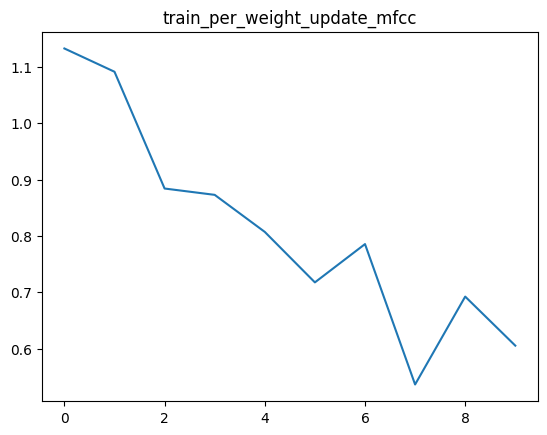

In [27]:
plt.plot(train_per_weight_update_mfcc)
plt.title("train_per_weight_update_mfcc")

Text(0.5, 1.0, 'train_per_weight_update_spec')

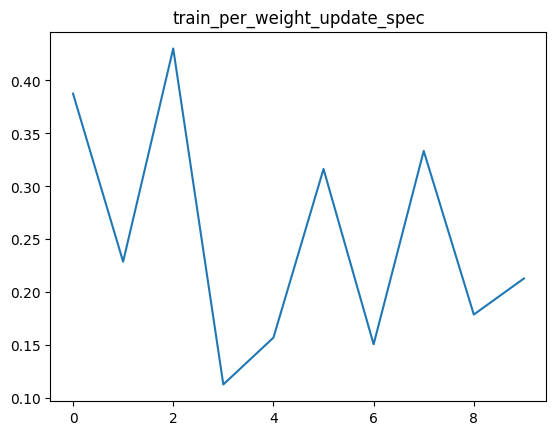

In [29]:
plt.plot(train_per_weight_update_spec)
plt.title("train_per_weight_update_spec")

Text(0.5, 1.0, 'val_accu_lst_mfcc')

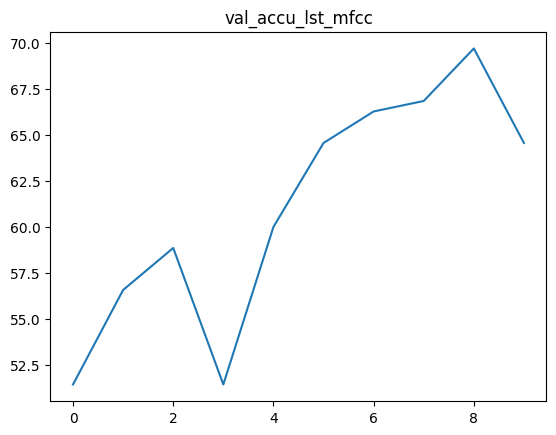

In [28]:
plt.plot(val_accu_lst_mfcc)
plt.title("val_accu_lst_mfcc")

Text(0.5, 1.0, 'val_accu_lst_spec')

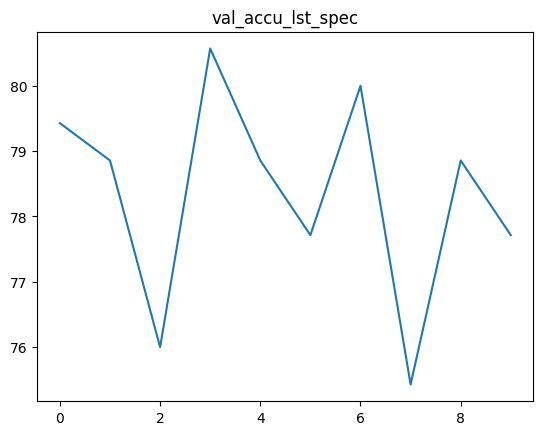

In [23]:
plt.plot(val_accu_lst_spec)
plt.title("val_accu_lst_spec")